<a href="https://colab.research.google.com/github/Gk58IISERTvm98/Titanic_Passanger_Survivals/blob/main/Notebooks/model_building.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np

In [3]:
train = pd.read_csv('/content/Titanic_Passanger_Survivals/Titanic_data/Preprocessed_train.csv')
test = pd.read_csv('/content/Titanic_Passanger_Survivals/Titanic_data/Preprocessed_test.csv')

In [4]:
train = train.drop(['Age_Band','FareBand'], axis=1)
train = train.iloc[:, 1:]

In [5]:
correlation_matrix = train.corr()
survived_correlation = correlation_matrix['Survived'].sort_values(ascending=False)

print(survived_correlation)

Survived         1.000000
Sex              0.543351
Title            0.407753
FareOnehot       0.301792
Total_Membors    0.276512
Fare             0.257482
FarePerMember    0.196784
Embarked         0.106811
Parch            0.081629
FamilySize       0.016639
relatives        0.016639
SibSp           -0.035322
AgeOneHot       -0.040452
Age             -0.070003
IsAlone         -0.203367
Age*Class       -0.335880
Pclass          -0.338481
Name: Survived, dtype: float64


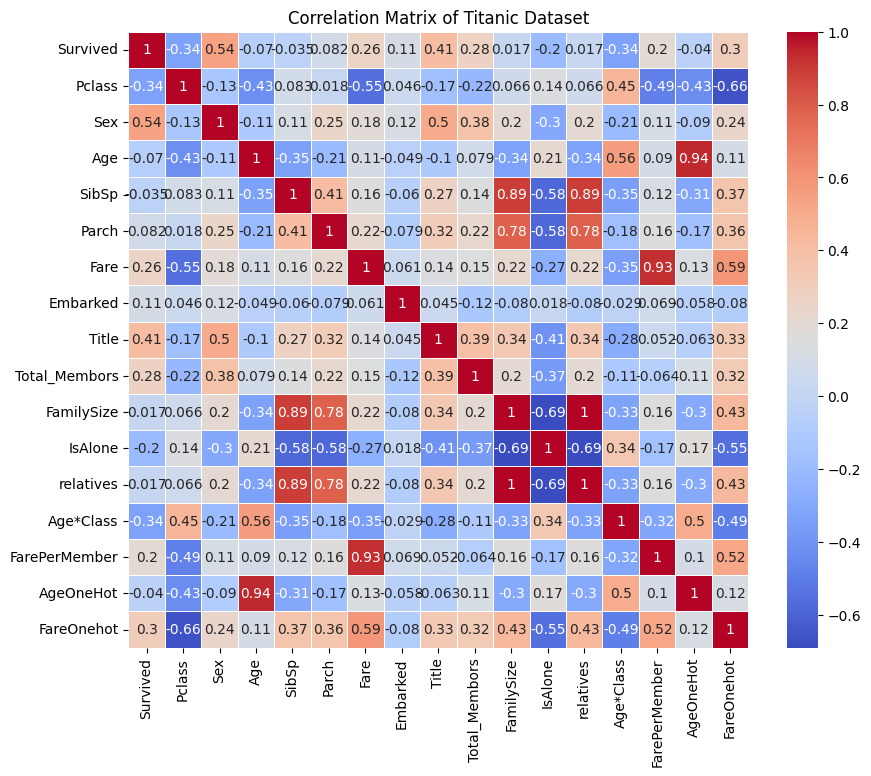

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Titanic Dataset')
plt.show()


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

X = train.drop(['Survived', 'Pclass', 'Age', 'IsAlone','Age*Class','SibSp'], axis = 1)
Y = train['Survived']

X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.2, random_state=42)


# RandomForestClassifier

In [8]:
from sklearn.ensemble import RandomForestClassifier
classifier =  RandomForestClassifier(n_estimators=100, criterion = 'entropy')
classifier.fit(X_train, Y_train)

y_pred = classifier.predict(X_train)
cm = confusion_matrix(Y_train, y_pred)
print(cm)
accuracy_score(Y_train, y_pred)


[[432  12]
 [ 33 235]]


0.9367977528089888

**Parameter Tunning with GridSearchCV**

In [9]:
from sklearn.model_selection import GridSearchCV

classifier = RandomForestClassifier()
parameters = {"criterion" : ["gini", "entropy"],
              'min_samples_leaf': [1, 2, 4],
              'min_samples_split': [2, 5, 10],
              'max_depth': [3, 5, 7],
              'n_estimators': [100, 200, 300]
              }


grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10,
                           n_jobs = -1)
grid_search.fit(X_train, Y_train)

best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)


Best Accuracy: 83.00 %
Best Parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}


# Decision_Tree_Classifier

In [10]:
from sklearn.tree import DecisionTreeClassifier

classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
classifier.fit(X_train, Y_train)

y_pred = classifier.predict(X_train)
cm = confusion_matrix(Y_train, y_pred)
print(cm)
accuracy_score(Y_train, y_pred)

[[436   8]
 [ 37 231]]


0.9367977528089888

# XGBClassifier

In [11]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

classifier = XGBClassifier(n_estimators = 300, learning_rate = 0.1,max_depth = 3, random_state = 0)
classifier.fit(X_train, Y_train)

y_pred = classifier.predict(X_train)
cm = confusion_matrix(Y_train, y_pred)
print(cm)
accuracy_score(Y_train, y_pred)


[[423  21]
 [ 50 218]]


0.9002808988764045

**Parameter Estimating Using RandomizedSearch**

In [12]:
classifier = XGBClassifier()

param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'random_state': [0]
}

random_search = RandomizedSearchCV(estimator=classifier,
                                   param_distributions=param_dist,
                                   n_iter=100,
                                   scoring='accuracy',
                                   cv=5,
                                   verbose=1,
                                   random_state=42)

random_search.fit(X_train, Y_train)

best_params = random_search.best_params_
best_score = random_search.best_score_

print("Best parameters:", best_params)
print("Best score:", best_score)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'subsample': 1.0, 'random_state': 0, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
Best score: 0.8229685807150595


# Stacking_Classifier

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

base_models = [
    ('rfc', RandomForestClassifier(n_estimators = 200,max_depth = 3, min_samples_split = 10, criterion = 'gini', random_state = 0)),
    ('gbc', GradientBoostingClassifier(random_state=0)),
    ('dtc', DecisionTreeClassifier(criterion = 'entropy', random_state = 0)),
    ('xgc', XGBClassifier()),
    ('svc', SVC(C = 0.71, kernel = 'rbf', gamma = 0.7, random_state = 0))]

meta_model = LogisticRegression()

classifier = StackingClassifier(estimators=base_models, final_estimator=meta_model)
classifier.fit(X_train, Y_train)

y_pred = classifier.predict(X_train)
cm = confusion_matrix(Y_train, y_pred)
print(cm)
accuracy_score(Y_train, y_pred)

[[411  33]
 [ 56 212]]


0.875

In [14]:
y_val_pred = classifier.predict(X_valid)
cm = confusion_matrix(Y_valid, y_val_pred)
print(cm)
accuracy_score(Y_valid, y_val_pred)

[[92 13]
 [18 56]]


0.8268156424581006